In [1]:
#Dependancies
import numpy as np
import math
import pandas as pd
from scipy.integrate import solve_ivp
from scipy.interpolate import CubicSpline
from scipy.optimize import fsolve, least_squares, minimize
from scipy.stats import qmc 
from scipy.linalg import norm
import random
import matplotlib.animation
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
from scipy.signal import argrelmin, argrelmax
import matplotlib.pyplot as plt
from numba import jit
from tabulate import tabulate

from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
%run Function_Master.ipynb

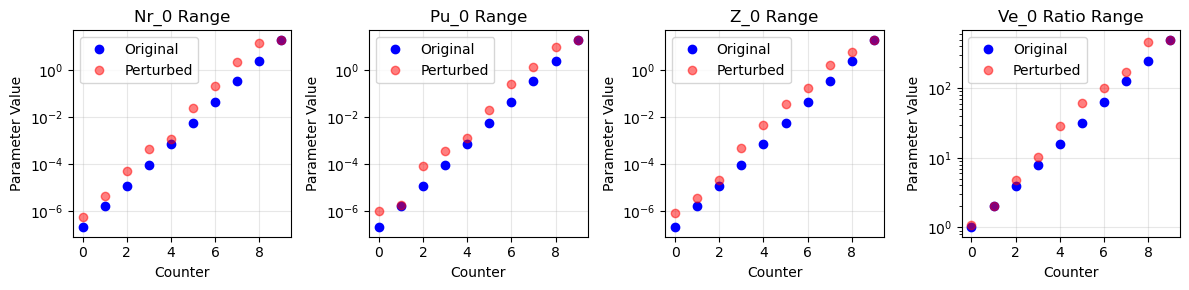

In [3]:
# Randomly perturbed points defining initial conditions

# Define initial ranges on logarithmic scaling since 
# we require more detail at smaller nutrient levels

points = 10
N_r_range = np.logspace(-7, 1, points) * 2
P_U_range = np.logspace(-7, 1, points) * 2
Z_range   = np.logspace(-7, 1, points) * 2
V_E_ratio = np.geomspace(1, 500, points)

ranges = [N_r_range, P_U_range, Z_range, V_E_ratio]
range_names = ["Nr_0", "Pu_0", "Z_0", "Ve_0 Ratio"]

perturbed_ranges = perturb_range(ranges, range_names, pprint=True)

In [4]:
#Base Parameterization

alpha = (1 / 1.42e8) * 2.1e-10 * 1e6 # host conversion, mmol ml / NT m^3
beta  = (1 / 4e5) * 1.27e-15 * 1e6   # viral conversion, mmol ml / NT m^3

V_ind     = 4e5        # NT per individual virus, Table S1
S_ind     = 1.42e8     # NT per individual host, Table S1

V_max     = 1.4              # Host growth rate
γ_Z       = .4               # Growth rate / Assimilation frequency 
φ         = 3.5e-10 / beta   # Viral adsorption rate, m^3 / (mmol * day)
g         = 1.4              # d^-1 Maximum specific grazing rate

ν_x       = V_ind / (V_ind + S_ind) # Proportion of nutrients originating 
                                    # from virus in host-virus pair
    
λ_P       = .05        # Mortality & Respiration rate

### Zooplankton mortality terms redefined later
λ_Z       = 0
λ_Z_hat   = 0

λ_E       = .1        # ARBITRARY VALUE: Extracellular virus mortality 
δ         = .45        # Host lysis rate

μ_V       = .5         # Max host NT recycling rate 
μ_V_prime = 1.6        # Max de novo NT synthesis rate
μ_u       = 0
μ_r       = 0          # Viral assimilation fraction related to host mortality
μ_s       = 1
μ_P       = .4         # Remineralization fraction due to mortality
μ_delta   = .4         # ARBITRARY VALUE: Remineralization fraction due to lysis
μ_g       = .4         # Remineralization fraction due to sloppy-eating
μ_Z       = .4         # Remineralization fraction due to grazer mortality

K_N       = .1         # mmol m^-3 # Half-saturation constant for nutrient limitation
K_I       = 1          # Half-saturation for light limitation
K_h       = 1          # Half-saturation for ... ?
K_P       = 2.8        # mmol m^-3, Half-saturation constant for grazing of P
I_0       = (np.e - 1) # Compensation irradiance

ω         = 0 # Entraintment term

param_labels = ['V_max', 'γ_Z', 'φ', 'g', 'ν_x', 'λ_P', 'λ_Z', 'λ_Z_hat', 'λ_E', 
                'δ', 'μ_V', 'μ_V_prime', 'μ_u', 'μ_r', 'μ_s', 'μ_P', 'μ_delta', 
                'μ_g', 'μ_Z', 'K_N', 'K_I', 'K_h', 'K_P', 'I_0', 'ω']

param = [V_max, γ_Z, φ, g, ν_x, λ_P, λ_Z, λ_Z_hat, λ_E, δ, μ_V, μ_V_prime, 
          μ_u, μ_r, μ_s, μ_P, μ_delta, μ_g, μ_Z, K_N, K_I, K_h, K_P, I_0, ω]

In [6]:
param_labels_fp = ['V_max', 'γ_Z', 'φ = 3.5e-10 / beta', 'g', 'ν_x = V_ind / (V_ind + S_ind)', 
                   'λ_P', 'λ_Z', 'λ_Z_hat', 'λ_E', 'δ', 'μ_V', 'μ_V_prime', 'μ_u', 'μ_r', 'μ_s', 
                   'μ_P', 'μ_delta', 'μ_g', 'μ_Z', 'K_N', 'K_I', 'K_h', 'K_P', 'I_0 = e - 1', 'ω']

print_paramterization(param, param_labels_fp)

╒════════════════════════════════════════╤═════════════╤═════════════════╤═══════════════╤══════════════════════╕
│ V_max = 1.4                            │ λ_P = 0.05  │ μ_V = 0.5       │ μ_P = 0.4     │ K_I = 1              │
├────────────────────────────────────────┼─────────────┼─────────────────┼───────────────┼──────────────────────┤
│ γ_Z = 0.4                              │ λ_Z = 0     │ μ_V_prime = 1.6 │ μ_delta = 0.4 │ K_h = 1              │
├────────────────────────────────────────┼─────────────┼─────────────────┼───────────────┼──────────────────────┤
│ φ = 3.5e-10 / beta = 110236.2205       │ λ_Z_hat = 0 │ μ_u = 0         │ μ_g = 0.4     │ K_P = 2.8            │
├────────────────────────────────────────┼─────────────┼─────────────────┼───────────────┼──────────────────────┤
│ g = 1.4                                │ λ_E = 0.1   │ μ_r = 0         │ μ_Z = 0.4     │ I_0 = e - 1 = 1.7183 │
├────────────────────────────────────────┼─────────────┼─────────────────┼──────────────